In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import library
import cv2
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
# Membaca Data
train_data = '/content/drive/MyDrive/Semester_4/PKAC/CV_Fire/Dataset_Fire/train'
print(os.listdir(train_data))

['fire', 'not_fire']


In [ ]:
# Membagi data menjadi 2 class
train_fire = os.listdir(os.path.join(train_data,'fire'))
train_not_fire = os.listdir(os.path.join(train_data,'not_fire'))

# Viewing the Images

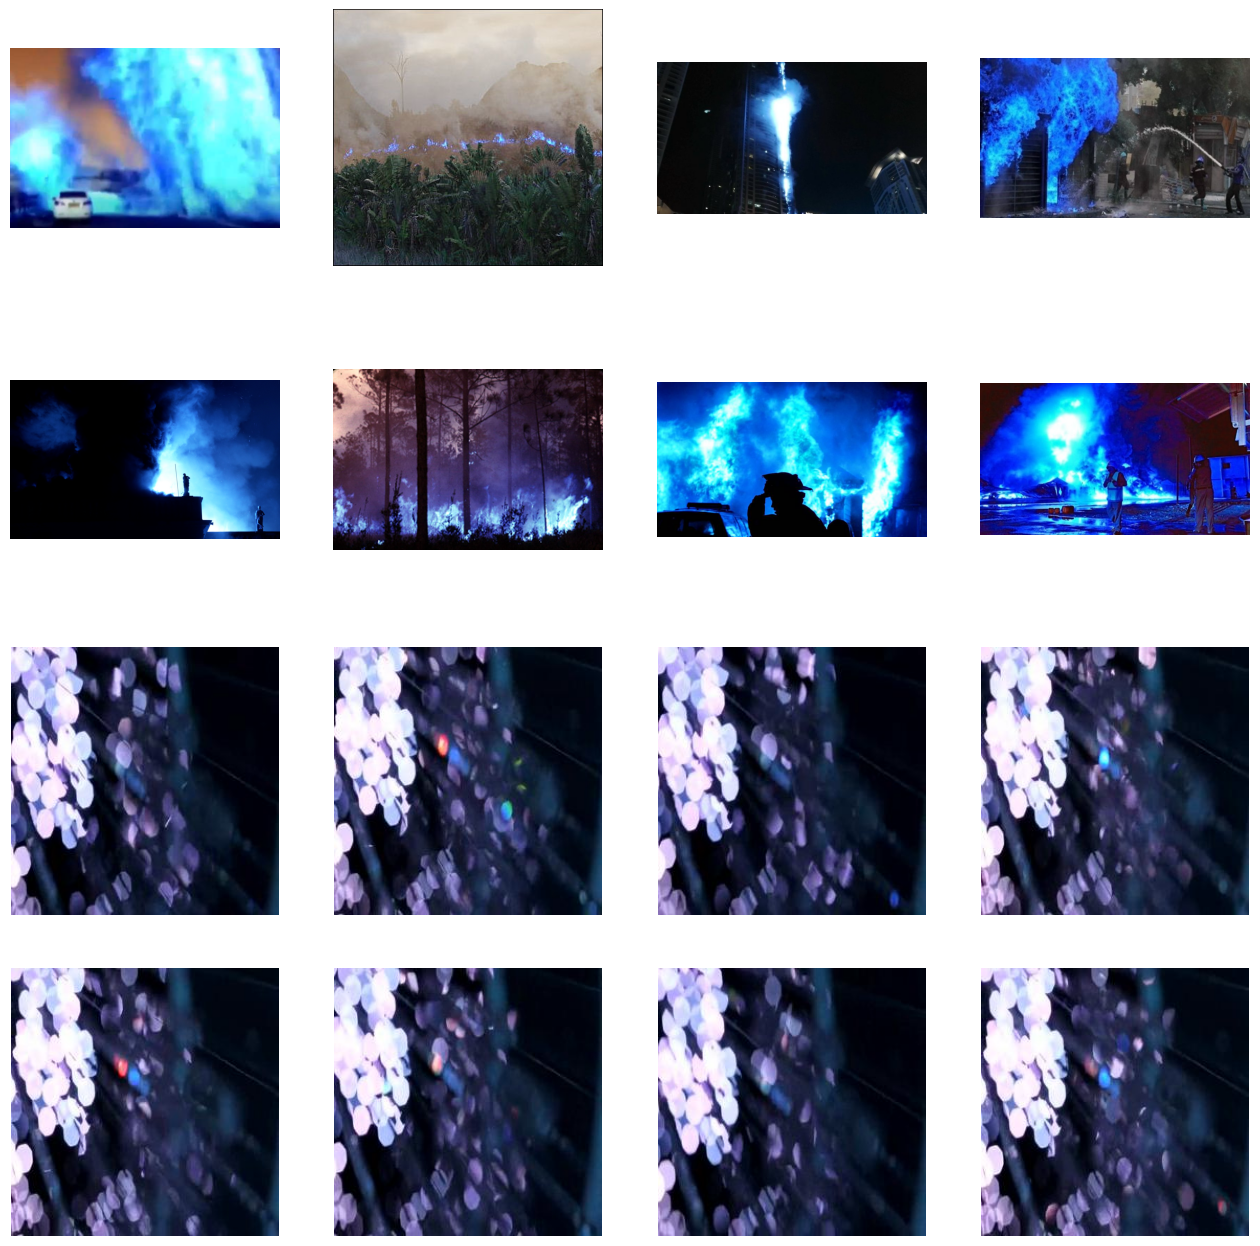

In [ ]:
# Jumlah gambar yang akan ditampilkan 4 baris 4 kolom
n_rows = 4
n_cols = 4

fig = plt.gcf()

# Size gambar
fig.set_size_inches(n_rows*4,n_cols*4)

fig_index=0
fig_index+=8

# Menampilkan 8 gambar pada masing-masing class
fire_8 = [os.path.join(train_data,'fire',fname) for fname in train_fire[fig_index-8:fig_index]]
not_fire_8 = [os.path.join(train_data,'not_fire',fname) for fname in train_not_fire[fig_index-8:fig_index]]

# Print image
for i,img_path in enumerate(fire_8+not_fire_8):
    sp = plt.subplot(n_rows,n_cols,i+1)
    sp.axis('Off')
    img = cv2.imread(img_path)
    plt.imshow(img)
plt.show()

# Image pre-processing

In [ ]:
# Menggunakan tensorflow ImageDataGenerator untuk membagi datasetmenjadi training dan validasi
train_gen = ImageDataGenerator(width_shift_range = 0.5,
                              height_shift_range = 0.5,
                              validation_split = 0.2)

train_set = train_gen.flow_from_directory(train_data,target_size = (300,300),class_mode = 'binary',subset = 'training',batch_size = 8)

validation_set = train_gen.flow_from_directory(train_data,target_size = (300,300),class_mode = 'binary',subset = 'validation',batch_size = 8)

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


# Building the Model

In [ ]:
# Menggunakan pre-trained Resnet-50 dan model sendiri untuk training dataset
pre_trained_resnet_50 = tf.keras.applications.ResNet50(include_top = False,
                                                      input_shape = (300,300,3),
                                                      pooling = 'avg',
                                                      classes = 100,
                                                      weights = 'imagenet')


# Freze 40 layer awal pada resnet
x = 0
for layer in pre_trained_resnet_50.layers:
    layer.trainable = False
    x+=1
    if x == 39:
        break

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Model
model = Sequential()
model.add(pre_trained_resnet_50)
model.add(Dense(2048,activation='relu'))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4000,activation='relu'))
model.add(Dense(2000,activation='relu'))
model.add(Dense(1000,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(250,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 8000)              32776000  
                                                                 
 dropout_1 (Dropout)         (None, 8000)              0         
                                                                 
 dense_3 (Dense)             (None, 4000)              3

**Using callbacks and optmizers**

In [ ]:
# Learning Rate
callback_lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

# Checkpoint dengan menggunakan validation loss terkecil sebagai model terbaik
modelcheck_lr = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Semester_4/PKAC/final_model.h5',monitor='val_loss',save_best_only = True)

model.compile(optimizer = tf.keras.optimizers.Adam() ,loss = 'binary_crossentropy',metrics = 'accuracy')

In [ ]:
# Now time to train our model on fire dataset
model_hist = model.fit(train_set,validation_data = validation_set,epochs = 50,callbacks = [callback_lr,modelcheck_lr])

Epoch 1/50
60/60 [==============================] - 87s 654ms/step - loss: 0.6961 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-08
Epoch 2/50
60/60 [==============================] - 32s 536ms/step - loss: 0.6959 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5000 - lr: 1.1220e-08
Epoch 3/50
60/60 [==============================] - 41s 690ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.5000 - lr: 1.2589e-08
Epoch 4/50
60/60 [==============================] - 25s 418ms/step - loss: 0.6968 - accuracy: 0.5021 - val_loss: 0.6926 - val_accuracy: 0.5000 - lr: 1.4125e-08
Epoch 5/50
60/60 [==============================] - 25s 419ms/step - loss: 0.6953 - accuracy: 0.5021 - val_loss: 0.6926 - val_accuracy: 0.5000 - lr: 1.5849e-08
Epoch 6/50
60/60 [==============================] - 24s 395ms/step - loss: 0.6964 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 1.7783e-08
Epoch 7/50
60/60 [======================

# Viewing the result of training

(1e-08, 0.001, 0.0, 1.0)

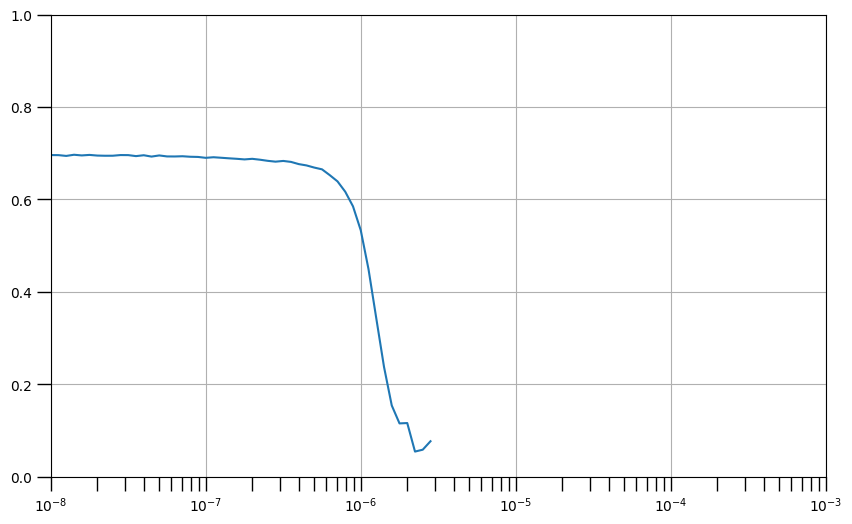

In [ ]:
# Membuat graph hasil training
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, model_hist.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 1])

# Time to check our model performance

In [ ]:
# Load best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Semester_4/PKAC/final_model.h5')
best_model.evaluate(validation_set)

15/15 [==============================] - 9s 485ms/step - loss: 0.0764 - accuracy: 0.9750


[0.07641390711069107, 0.9750000238418579]

# Testing

In [1]:
# Setup nilai deteksi secara manual
threshold_detection = 0.65 #rata-rata nilai deteksi fire adalah >0.6
threshold_segmentation = 0.0005 #menurunkan nilai ini dapat menyebabkan api tidak terdeteksi dengan baik

In [2]:
def visualize_segmentation(model, image_path):
    img_color = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (256, 256))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    img_preprocessed = preprocess_input(img_gray)

    # mengubah dimensi gambar dari (height, width, channels) menjadi (1, height, width, channels, 1) agar sesuai dengan model
    img_input = tf.expand_dims(img_preprocessed, axis=0)
    img_input = tf.expand_dims(img_input, axis=-1)

    # prediksi segmentasi api
    prediction = (model.predict(img_input) > threshold_segmentation).astype(np.uint8)

    # ubah ke hasil prediksi ke dalam api
    binary_image = np.squeeze(prediction)
    binary_image[binary_image == 1] = 255

    # Print hasil
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(img_rgb)
    plt.subplot(233)
    plt.title('Detected Part')
    plt.imshow(binary_image, cmap='gray')

    plt.show()

In [3]:
def fire_detection(model, image_path):
    img_color = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_preprocessed = preprocess_input(img_resized)

    img_input = tf.expand_dims(img_preprocessed, axis=0)

    # Prediksi
    prediction = model.predict(img_input)
    fire_probability = prediction[0][0]

    return fire_probability

In [4]:
def detect(image):

  # load model fire detection
  detection_model = best_model

  # Load model U-Net segmentation 
  segmentation_model = load_model('/content/drive/MyDrive/Semester_4/PKAC/CV_Fire/unet_model/model.hdf5')

  # prediksi api dengan model fire detection
  fire_probability = fire_detection(detection_model, image)

  class_names = ['Not-Fire', 'Fire']

  print("Image:", image)
  if fire_probability > threshold_detection:
      print("Fire detected. Performing segmentation...")
      visualize_segmentation(segmentation_model, image)
  else:
      black_img = np.zeros((256, 256), dtype=np.uint8)  # Create a black image of desired size      
      img_color = cv2.imread(image)
      img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

      plt.figure(figsize=(16, 8))
      plt.subplot(231)
      plt.title('Testing Image')
      plt.imshow(img_rgb)
      plt.subplot(233)
      plt.title('Tidak Terdeteksi')
      plt.imshow(black_img, cmap='gray')

      plt.show()

1/1 [==============================] - 0s 34ms/step
Image: /content/pexels-photo-2033933.jpeg
Fire detected. Performing segmentation...
1/1 [==============================] - 1s 563ms/step


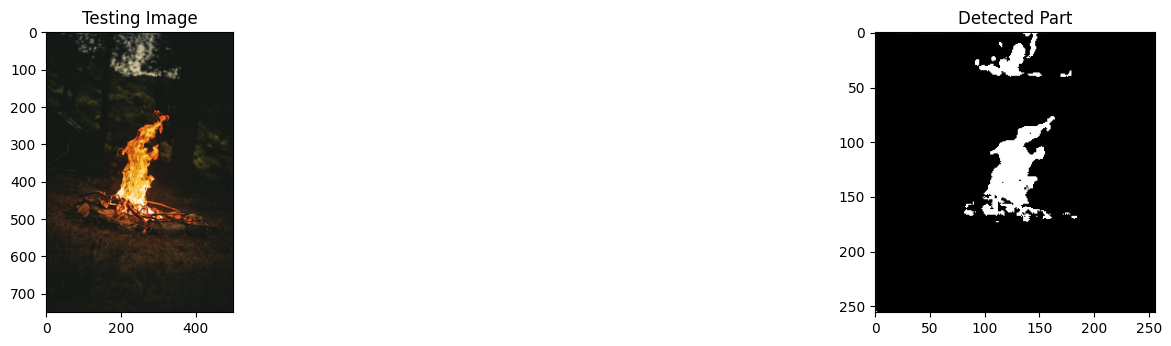

In [ ]:
detect('/content/photo-1517594422361-5eeb8ae275a9.jpeg')

In [ ]:
detect('/content/sapi1.jpg')

1/1 [==============================] - 0s 24ms/step
Image: /content/sapi1.jpg
No fire detected. Can't perform Detection.
